In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from kvae import VariationalAutoencoder

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [4]:
batch_size = 128
latent_dim = 2

intermediate_dims = [512, 256, 128, 64] # 137.45

epochs = 10

In [5]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_dim = x_train.shape[1]

x_train.shape, x_test.shape, input_dim

((60000, 784), (10000, 784), 784)

In [6]:
vae = VariationalAutoencoder(input_dim, intermediate_dims, latent_dim,
                             epsilon_std=0.3)

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          32896       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

/home/yannick/Work/github/Spikes/python/kvae.py:89: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  vae.compile(optimizer='rmsprop', loss=None)


In [7]:
%%time

from random import seed

seed(42)

history = vae.fit(x_train,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10

60000/60000 [==============================] - ETA: 0s - loss: 188.9247 - val_loss: 167.6012
Epoch 2/10

32128/60000 [===============>..............] - ETA: 2s - loss: 161.9924


60000/60000 [==============================] - ETA: 0s - loss: 158.8681 - val_loss: 154.9588
Epoch 3/10

60000/60000 [==============================] - ETA: 0s - loss: 151.0579 - val_loss: 150.8671
Epoch 4/10

15104/60000 [======>.......................] - ETA: 2s - loss: 149.2641


60000/60000 [==============================] - ETA: 0s - loss: 147.6763 - val_loss: 145.3797
Epoch 5/10

60000/60000 [==============================] - ETA: 0s - loss: 145.7937 - val_loss: 145.9639
Epoch 6/10

 2048/60000 [>.............................] - ETA: 3s - loss: 145.7075


60000/60000 [==============================] - ETA: 0s - loss: 144.2588 - val_loss: 142.4876
Epoch 7/10

53504/60000 [=========================>....] - ETA: 0s - loss: 142.5165


60000/60000 [==============================] - ETA: 0s - loss: 142.5663 - val_loss: 141.9256
Epoch 8/10

60000/60000 [==============================] - ETA: 0s - loss: 141.7834 - val_loss: 141.8803
Epoch 9/10

44288/60000 [=====================>........] - ETA: 1s - loss: 141.2459


60000/60000 [==============================] - ETA: 0s - loss: 141.3508 - val_loss: 143.2294
Epoch 10/10

60000/60000 [==============================] - ETA: 0s - loss: 142.7319 - val_loss: 151.1794
CPU times: user 43.4 s, sys: 2.19 s, total: 45.6 s
Wall time: 37 s


In [8]:
vae.save("/home/yannick/tmp/vae.json", "/home/yannick/tmp/w.h5")

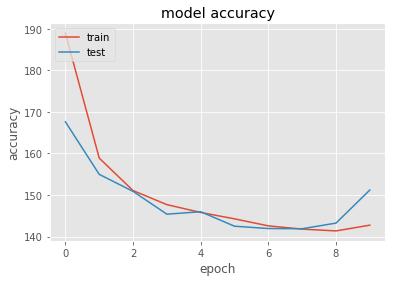

In [9]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
_ = plt.legend(['train', 'test'], loc='upper left')

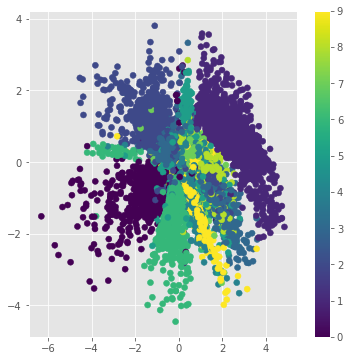

In [10]:
x_test_encoded = vae.encode(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()

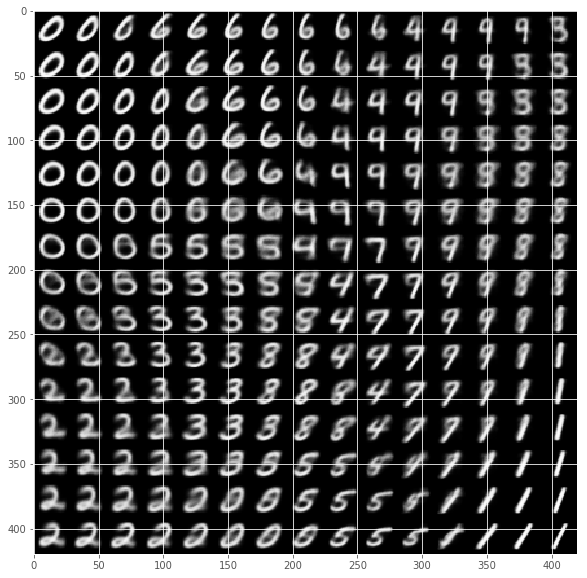

In [11]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.generate(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

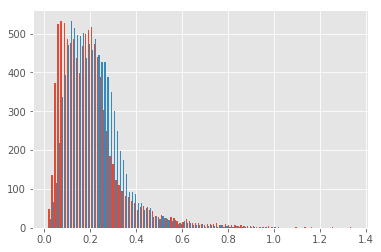

In [12]:
z_sigma_test = vae.sigmaEncode(x_test, batch_size=batch_size)

_ = plt.hist(z_sigma_test, bins=100)

In [13]:
dirs = "/tmp/h5/"

! mkdir {dirs}

In [14]:
vae.vae.save_weights(dirs + "w.h5")

! ls -lh {dirs}

total 4,5M
-rw-r--r-- 1 yannick yannick 4,5M oct.  21 16:24 w.h5


In [15]:
from keras.models import load_model

# m = load_model(dirs + "vae.h5")

In [16]:
foo = VariationalAutoencoder(input_dim, intermediate_dims, latent_dim,
                             epsilon_std=0.3)
foo.vae.load_weights(dirs + "w.h5")

foo.summary()

/home/yannick/Work/github/Spikes/python/kvae.py:89: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.
  vae.compile(optimizer='rmsprop', loss=None)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 512)          401920      input_3[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 256)          131328      dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 128)          32896       dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (

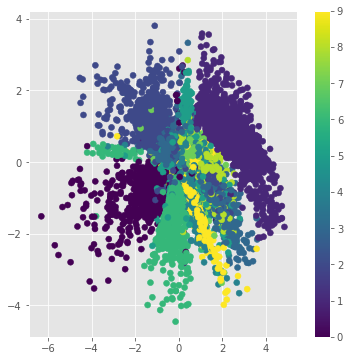

In [17]:
x_test_encoded = foo.encode(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()

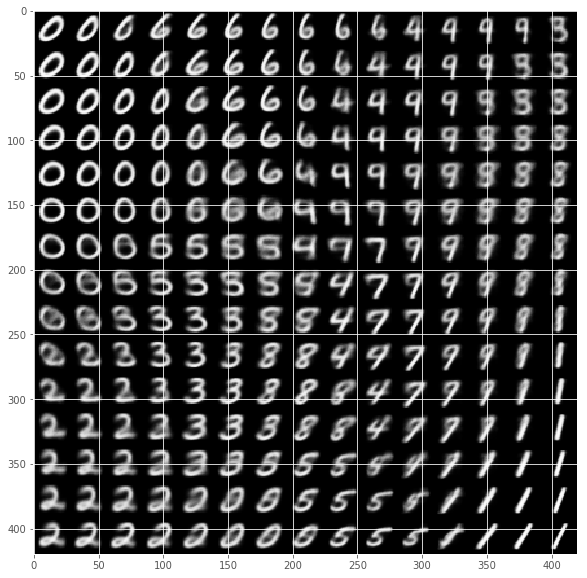

In [18]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = foo.generate(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

In [19]:
list(zip(foo.__dict__))

[('input_dim',),
 ('hidden_dims',),
 ('latent_dim',),
 ('epsilon_std',),
 ('_version',),
 ('vae',),
 ('encoder',),
 ('decoder',),
 ('zlogvarEncoder',)]

In [20]:
type(0.3) in [float, int]

True

In [21]:
import json

with open("/tmp/foo.json", "w") as outfile:
    json.dump({'a': 'b', 'c': [1,2]}, outfile)

In [22]:
outfile

<_io.TextIOWrapper name='/tmp/foo.json' mode='w' encoding='UTF-8'>